> ### Imports

In [1]:
import os
import numpy as np
import pandas as pd

from iqual import tests

> ### Load datasets

In [2]:
data_dir    = "../data"

### Qualitative data (Enhanced Data with progressive k-fold bootstrap)
bootstrap_df  = pd.read_csv(os.path.join(data_dir,"enhanced_bootstrap_kfold.csv"))

### Quantitative data
quant_df      = pd.read_csv(os.path.join(data_dir,"quant_data.csv"))

> ### Variables

In [3]:
annotation_vars = ["ability_low","secular"]

id_vars         = ['uid','split','data_round','refugee','bootstrap_run','train_sample_size']

> ### Enhanced Bootstrap Dataframe (Merged with quantiative data)

In [4]:
bootstrap_df = bootstrap_df[[*id_vars,*annotation_vars]].copy()
bootstrap_df = pd.merge(bootstrap_df,quant_df,on=['uid','data_round','refugee'],how='left')

> ### Regression Configuration

In [5]:
# Numerical regressors (Continuous/Dummy variables)
numerical_vars = [
     'refugee',
     'hh_head_sex',
     'eld_sex',
     'parent_reledu',
     'num_child',
     'hh_head_age',
     'parent_eduyears',
     'eld_age',
     'hh_asset_index',
     'hh_income',
     'int_trauma_exp',
]

In [6]:
import itertools

N_DRAWS        = 100
HUMAN_SIZES    = [100, 200, 400, 700]
MACHINE_SIZES  = [200, 400, 600, 800, 1000, 1200, 1400]
BOOTSTRAP_RUNS = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

ANNOTATIONS = ['ability_low','secular']
REGRESSORS  = ['refugee','eld_sex']
regressor_params = dict(zip(ANNOTATIONS,REGRESSORS))

In [7]:
bootstrap_grouped = bootstrap_df.groupby(['train_sample_size','bootstrap_run'])

In [8]:
coefs = []

for h, r, m in itertools.product(HUMAN_SIZES, BOOTSTRAP_RUNS, MACHINE_SIZES):
    print("\r...| ","Bootstrap Run:",r,"Human:",h,"Machine:",m,sep=' ',end=' | ...')
    
    df = bootstrap_grouped.get_group((h,r))
    
    human_df = df[df.split == 'train'].sample(h)
    human_model = tests.StatsModel(
        human_df,
        annotation_vars=ANNOTATIONS,
        numerical_regressors=numerical_vars,
    ).fit_all()
    for annotation, regressor in regressor_params.items():
        human_coef = human_model.get_model_coefficient(annotation,regressor)

        coefs.append({
            'sample': 'human',
            'annotation': annotation,
            'regressor': regressor,
            'coefficient': human_coef,
            'n_h': h,
            'n_m': m,
        })
    
    for _ in range(N_DRAWS):
        machine_df = df[df.split != 'train'].sample(m)
        enh_df     = pd.concat([human_df, machine_df])
        enh_model  = tests.StatsModel(
            enh_df,
            annotation_vars=ANNOTATIONS,
            numerical_regressors=numerical_vars,
        ).fit_all()
        for annotation, regressor in regressor_params.items():
            enh_coef = enh_model.get_model_coefficient(annotation,regressor)

            coefs.append({
                'sample': 'enhanced',
                'annotation': annotation,
                'regressor': regressor,
                'coefficient': enh_coef,
                'n_h': h,
                'n_m': m,
            })

coef_data = pd.DataFrame(coefs)

...|  Bootstrap Run: 1 Human: 100 Machine: 600 | ...


KeyboardInterrupt



> ## Regression Coefficient Plots

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", font_scale=0.7)

> ### `Low Ability` (Coefficient on `Refugee`)

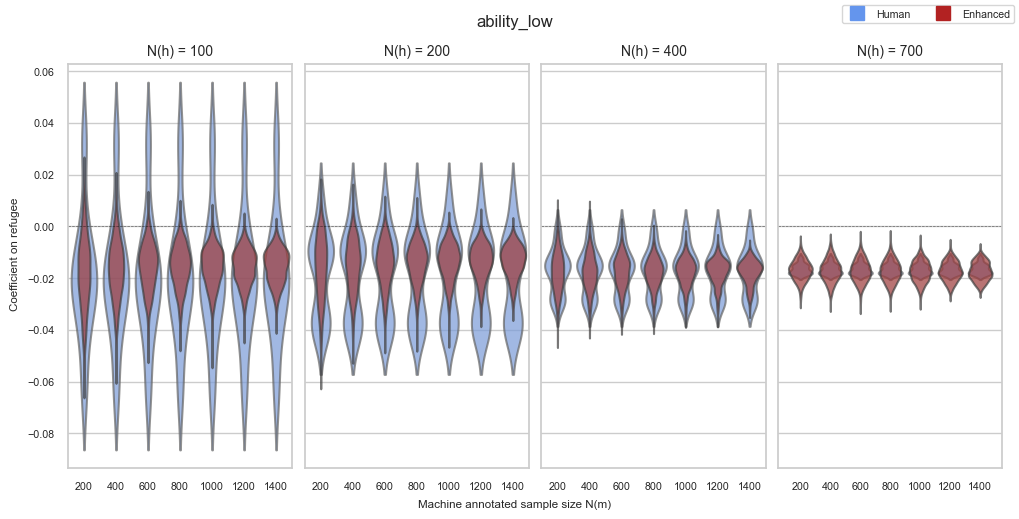

In [11]:
ANNOTATION = 'ability_low'
REGRESSOR  = regressor_params[ANNOTATION]

# Coefficients for annotation
coef_df = coef_data[coef_data.annotation==ANNOTATION]

fig, axs = plt.subplots(nrows=1, ncols=4, sharey=True, figsize=(10, 5))

# Iterate over N(h) 
for i, h in enumerate(HUMAN_SIZES):    
    df = coef_df[(coef_df.n_h==h)]
    
    # Zeroline
    axs[i].axhline(y=0, ls='--', color='black',alpha=0.5, lw=0.5)
    
    # Human sample
    sns.violinplot(x=df[df['sample']=='human'].n_m,
                   y=df[df['sample']=='human'].coefficient,
                   inner=None,
                   ax=axs[i],
                   saturation=0.7,
                   color='cornflowerblue',
                  )
    
    # Enhanced sample
    sns.violinplot(x=df[df['sample']=='enhanced'].n_m,
                   y=df[df['sample']=='enhanced'].coefficient,
                   ax=axs[i],
                   inner=None,
                   saturation=0.7,
                   color='firebrick',
                  )
    
    # Subplot title
    axs[i].set_title(f"N(h) = {h}", fontsize=10)
    
    # Removing redundant xy axis labels
    axs[i].set(ylabel=None,xlabel=None)
    
    # Alpha of violins
    plt.setp(axs[i].collections, alpha=0.7)

    
# Add legends
human_patch = plt.plot([], [], color='cornflowerblue', label='Human', marker='s', markersize=10, linestyle='')[0]
enhanced_patch = plt.plot([], [], color='firebrick', label='Enhanced', marker='s', markersize=10, linestyle='')[0]
fig.legend(handles=[human_patch, enhanced_patch], loc='upper right', ncol=2)

# Layout
fig.subplots_adjust(wspace=0.01,)
fig.suptitle(ANNOTATION, fontsize=12)
# Y-axis title
fig.text(1e-4, 0.5, f"Coefficient on {REGRESSOR}", ha='center', va='center', rotation='vertical')
# X-axis title
fig.text(0.5, 1e-4 ,"Machine annotated sample size N(m)",ha='center', va='center',)
fig.tight_layout()

> ### `Secular Aspirations` (Coefficient on `Female Eldest Child`)

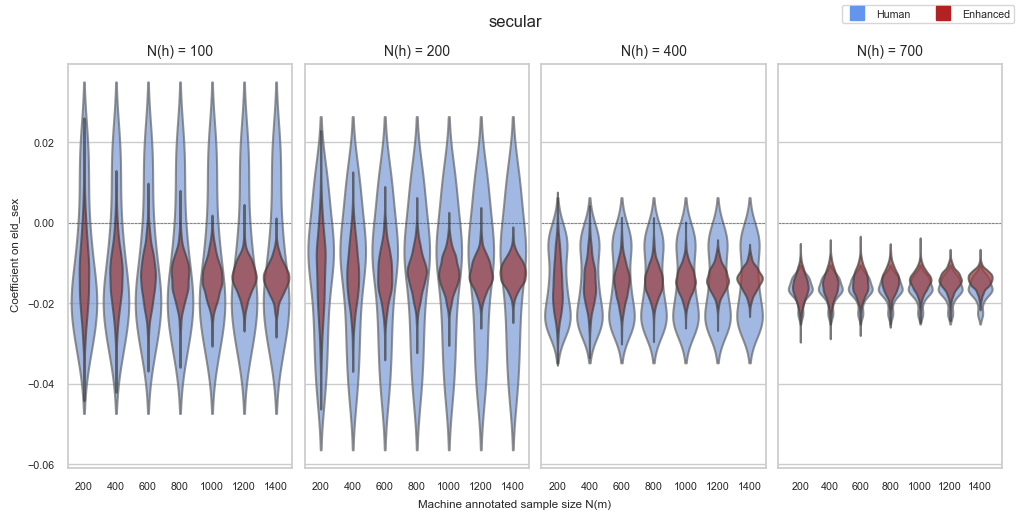

In [12]:
ANNOTATION = 'secular'
REGRESSOR  = regressor_params[ANNOTATION]

# Coefficients for annotation
coef_df = coef_data[coef_data.annotation==ANNOTATION]

fig, axs = plt.subplots(nrows=1, ncols=4, sharey=True, figsize=(10, 5))

# Iterate over N(h) 
for i, h in enumerate(HUMAN_SIZES):    
    
    df = coef_df[(coef_df.n_h==h)]    
    
    # Zeroline
    axs[i].axhline(y=0, ls='--', color='black',alpha=0.5, lw=0.5)
    
    # Human sample
    sns.violinplot(x=df[df['sample']=='human'].n_m,
                   y=df[df['sample']=='human'].coefficient,
                   inner=None,
                   ax=axs[i],
                   saturation=0.7,
                   color='cornflowerblue',
                  )
    
    # Enhanced sample
    sns.violinplot(x=df[df['sample']=='enhanced'].n_m,
                   y=df[df['sample']=='enhanced'].coefficient,
                   ax=axs[i],
                   inner=None,
                   saturation=0.7,
                   color='firebrick',
                  )
    
    # Subplot title
    axs[i].set_title(f"N(h) = {h}", fontsize=10)
    
    # Removing redundant xy axis labels
    axs[i].set(ylabel=None,xlabel=None)
    
    # Alpha of violins
    plt.setp(axs[i].collections, alpha=0.7)

    
# Add legends
human_patch = plt.plot([], [], color='cornflowerblue', label='Human', marker='s', markersize=10, linestyle='')[0]
enhanced_patch = plt.plot([], [], color='firebrick', label='Enhanced', marker='s', markersize=10, linestyle='')[0]
fig.legend(handles=[human_patch, enhanced_patch], loc='upper right', ncol=2)

# Layout
fig.subplots_adjust(wspace=0.01,)
# Figure Title
fig.suptitle(ANNOTATION, fontsize=12)
# Y-axis title
fig.text(1e-4, 0.5, f"Coefficient on {REGRESSOR}", ha='center', va='center', rotation='vertical')
# X-axis title
fig.text(0.5, 1e-4 ,"Machine annotated sample size N(m)",ha='center', va='center',)

fig.tight_layout()